# Noise analysis

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.fft import fft
import scipy.stats as stats

In [2]:
# Auxiliary functions

def normal_pdf(x, mu, sigma):
    return np.exp(-(x-mu)**2/(2*sigma**2))/(np.sqrt(2*np.pi*sigma**2))

def get_data(idx_meas=0, idx_channel=0):
    """
    Read the time [s] and current [uA] array from file specified by measurement 
    and channel indices.
    
    Input:
    idx_meas - (int) measurement index; range: [0, 14]
    idx_channel - (int) channel index; range: [0, 7]
    
    Output:
    t - (float array) time values [s]
    i - (float array) current values [pA]
    """

    fname0 = '20230614_CA_noise_test_chamberopen_with pins_0_0_0_' 

    fname = fname0+str(idx_meas)+'_'+str(idx_channel)+'.csv'

    df = pd.read_csv(path+fname, skiprows=[0, 1], sep=';')
    df = df.rename(columns=lambda x: x.strip())

    t = np.array(df['V'])
    i = 1e6*np.array(df['uA']) # i is returned in [pA]
    # print(fname)

    return t, i

def get_i_stat(i, outlier_n_std=4, print_yn=False):
    """
    Perform basic statistic analyis of the array of current values.
    
    The function does the following:
    1) Evaluate the mean (i_mu) and STD (i_sigma) of the entire set i
    2) Decide which points are outliers ("bad"), defined as being more than oulier_n_std*i_std away from i_mu,
        and denote all the other points as "good"
    3) Re-evaluate the mean (i_good_mu) and STD (i_good_sigma) considering only the set of "good" points.
    
    Input:
    i - (float array) current values, as read by get_data(...)
    outlier_n_std - (float) distance from mean value beyond which a point is considered
                    to be an outlier (in units of STD(i))
    print_yn - (boolean) flab for deciding whether to print out the values
    
    Output:
    sp - (dict) dictionary containing the statistical parameters:
            N - total number of points
            N_bad - number of "bad" points
            i_good_sigma - STD over the set of "good" points
            i_good_mu - mean over the set of "good" points
    idx_good - (int array) indices of points in which the current value is within bounds,
                i.e. is considered "good" 
    idx_bad - (int array) indices of outlier ("bad") points.
    """

    
    sp = {}
    

    N = len(i)

    i_std = np.std(i)
    i_mu = np.mean(i)
    idx = np.arange(N)
    idx_bad = idx[np.abs(i-i_mu)>outlier_n_std*i_std]
    idx_good = idx[np.abs(i-i_mu)<=outlier_n_std*i_std]
    

    sp['N'] = N
    sp['N_bad'] = len(idx_bad)

    sp['i_good_sigma'] = np.std(i[idx_good])
    sp['i_good_mu'] = np.mean(i[idx_good])
    
    sp['i_min'] = np.min(i)
    sp['i_max'] = np.max(i)

    
    if print_yn:
        print(f'({idx_meas}, {idx_channel}): ', end='')
        for k in sp.keys():
            print(f'{k}={sp[k]:.1e}', end=' ')
        print('')
    
    return sp, idx_good, idx_bad

## Check consistency of t

Check if all recordings are sampled the same duration and at identical intervals (so we can analyze the i-data independently).

In [3]:
path = 'task_1_noise_analysis/'

consistent = True
for idx_channel in range(8):
    for idx_meas in range(15):

        t, i = get_data(idx_meas, idx_channel)
        
        t_min, t_max = np.min(t), np.max(t)
        dt_min, dt_max = np.min(np.diff(t)), np.max(np.diff(t))

        if (idx_channel, idx_meas) == (0, 0):
            t_min0, t_max0 = t_min, t_max
            dt_min0, dt_max0 = dt_min, dt_max
            
        else:
            buf = np.abs(t_min-t_min0)+np.abs(t_max-t_max0)+np.abs(dt_min-dt_min0)+np.abs(dt_max-dt_max0)
            if not np.isclose(buf, 0):
                print('ERROR: Inconsistent t values!')
                consistent = False
                break
    if not consistent:
        break

if consistent:
    print('All t values are consistent.')
    

All t values are consistent.


## Task 1: Visualize the noise data for each channel

Our basic aim in visualizing the data is to understand which part is noise and which part is "something else". Since the signal is expected to be mostly random noise, we assume that its should, for the most part, have a normal distribution. Consequently, outliers (also referred to as "bad" points) are defined as being "far" from the mean value. We do it this way because we have been not provided with any information (e.g. a physical model) about the nature of individual channels. 

In this case, "something else" turns out to be the transient response. 

In visualizing the data, we plot the following:

1. column: The entire set of measured points 
2. column: The set of "bad" (outlier) points 
3. column: The set of "good" points 
4. column: The normal Q-Q plot drawn for "good" points (to show they follow the normal distribution)
5. column: The Fourier transform (i.e. FFT) of the entire set, to check for any "hidden" signal components

Since, for regular channels, the "bad" points turn out to be the transient response, we denote this column by "Transient"

For the same reason, the "good" points are denoted by "Steady state".

The normal Q-Q plot is used for checking our hypothesis that the noise has a Normal distribution.



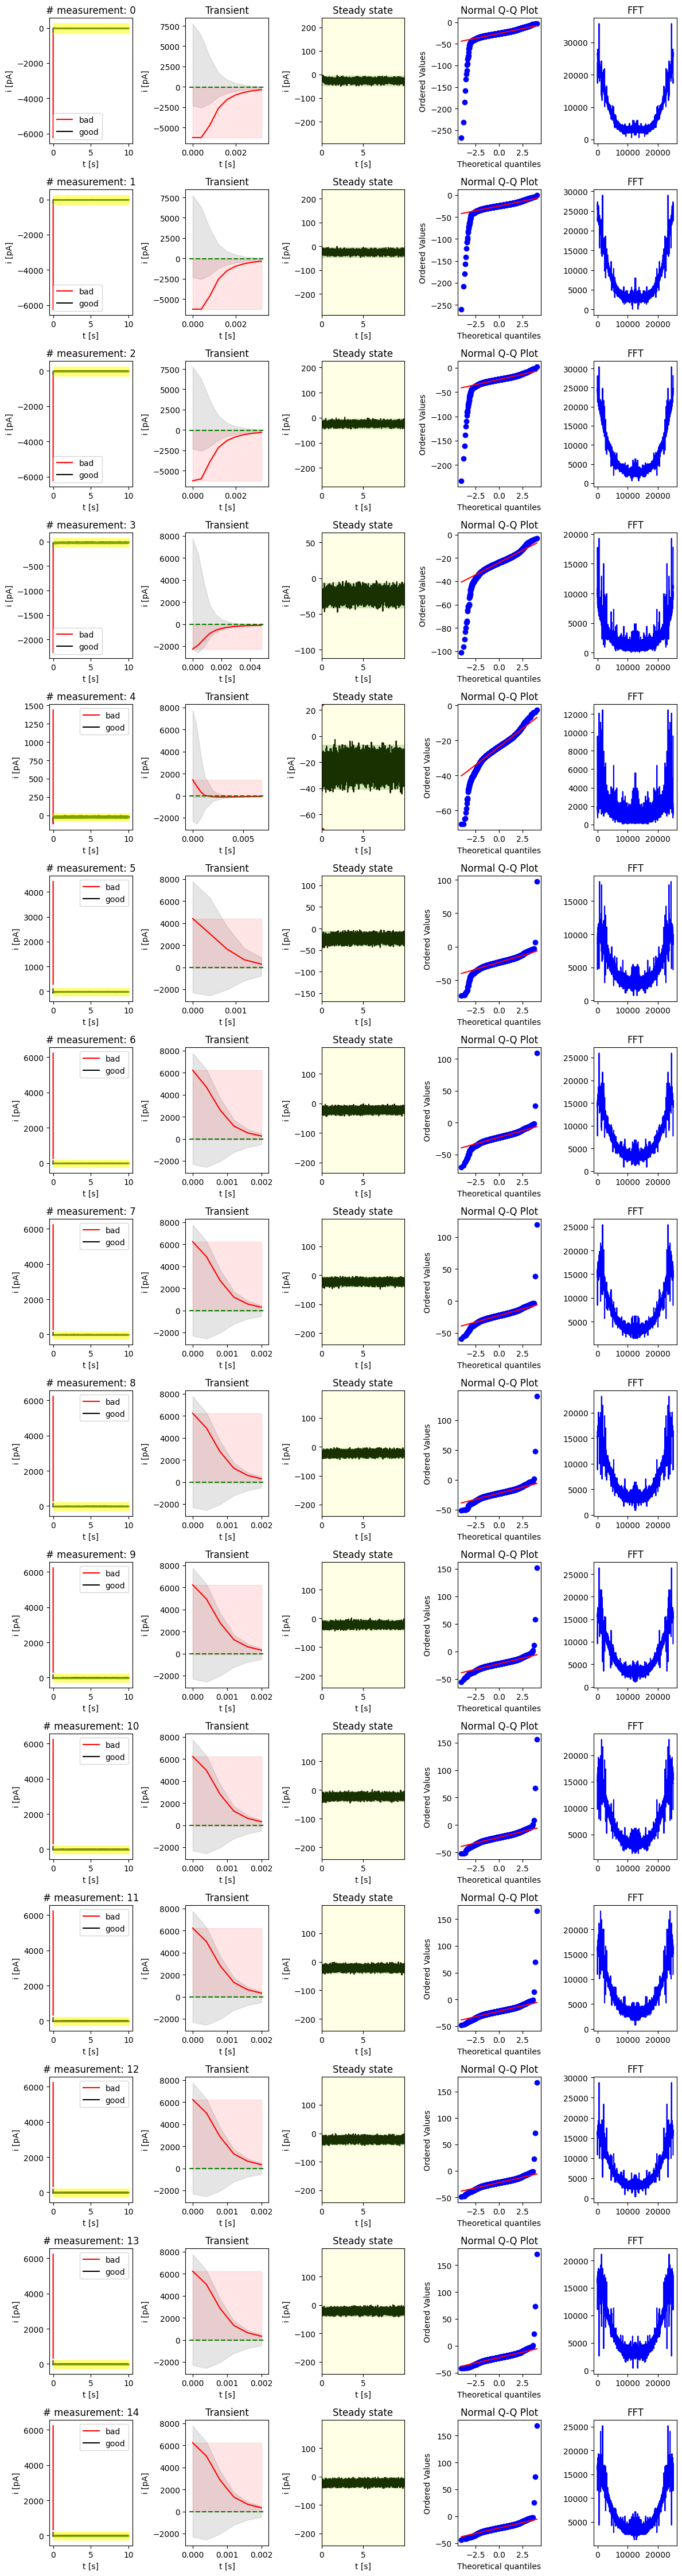

In [4]:
filename_pic = 'fig_noise_data'

path_output = 'task_1_noise_analysis_output_v2/' # name of the folder in which the 
                                              # generated images are recorded

idx_channel = 3 # channel to be plotted; select value from [0...7]
N_meas = 15 # 15 # plotted measurements are 0 ... N_meas; select value from [0...15]
            # for example, set N_meas=1 to plot only idx_meas = 0
            # set N_meas=15 to plot the entire dataset for given channel
N_cols = 5 # number of columns in the plot; do not change
nbins = 30

outlier_n_std = 4 # number of STDs from the mean that define "bad"; set value > 2

if not os.path.exists(path_output):
    print(f'Output folder {path_output} not found. Creating a new one.')
    os.makedirs(path_output)

i_good_mus = np.zeros(N_meas, dtype=np.float64) # array of 
i_good_sigmas = np.zeros(N_meas, dtype=np.float64)
i_N_bad = np.zeros(N_meas, dtype=np.int32)
idx_bad_min = np.zeros(N_meas, dtype=np.int32)
idx_bad_max = np.zeros(N_meas, dtype=np.int32)

i_idx_bads = []
    
# Load all data for selected channel
for idx_meas in range(N_meas):
    t, i = get_data(idx_meas, idx_channel)
    sp, idx_good, idx_bad = get_i_stat(i, outlier_n_std=outlier_n_std)
    i_good_mus[idx_meas] = sp['i_good_mu']
    i_good_sigmas[idx_meas] = sp['i_good_sigma']
    i_N_bad[idx_meas] = sp['N_bad']
    idx_bad_min[idx_meas] = np.min(idx_bad)
    idx_bad_max[idx_meas] = np.max(idx_bad)
    i_idx_bads.append(idx_bad)
    
    if idx_meas == 0: # initialize i_chs
        i_chs = np.zeros(shape=(N_meas, len(t)), dtype=np.float64)

    i_chs[idx_meas, :] = i[:]
    
i_chs_mu = np.mean(i_chs, axis=0)
i_chs_sigma = np.std(i_chs, axis=0)



# Plotting
fig, ax = plt.subplots(ncols=N_cols, nrows=N_meas, figsize=(12, 3*N_meas))
ax = ax.flatten()

for idx_meas in range(N_meas):
    
    i = i_chs[idx_meas, :]
    
    sp, idx_good, idx_bad = get_i_stat(i, outlier_n_std=outlier_n_std)
    
    bax = ax[idx_meas*N_cols+0]
    bax.plot(t[idx_bad], i[idx_bad], color='r', label='bad', zorder=0)
    bax.plot(t[idx_good], i[idx_good], color='k', label='good', zorder=0)



    bax.add_patch(Rectangle((np.min(t[idx_bad]), sp['i_min']), 
                            np.max(t[idx_bad])-np.min(t[idx_bad]), sp['i_max']-sp['i_min'], 
                            alpha=0.1,
                            color='red'))

    bax.add_patch(Rectangle((np.max(t[idx_bad]), sp['i_good_mu']-outlier_n_std*sp['i_good_sigma']), 
                            np.max(t)-np.max(t[idx_bad]), 2*outlier_n_std*sp['i_good_sigma'], 
                            alpha=0.5,
                            color='green'))
    bax.add_patch(Rectangle((np.min(t), sp['i_good_mu']-outlier_n_std*np.std(i)), 
                            np.max(t)-np.min(t), 2*outlier_n_std*np.std(i), 
                            alpha=0.5,
                            color='yellow'))

           
    bax.legend()
    bax.set_xlabel('t [s]')
    bax.set_ylabel('i [pA]')
    bax.set_title(f'# measurement: {idx_meas}')

    bax = ax[idx_meas*N_cols+1]
    bax.plot(t[idx_bad], i[idx_bad], color='r')
    bax.fill_between(t[idx_bad], i_chs_mu[idx_bad]-i_chs_sigma[idx_bad],
                    i_chs_mu[idx_bad]+i_chs_sigma[idx_bad], color='gray', alpha=0.2)
    
    bax.add_patch(Rectangle((np.min(t[idx_bad]), sp['i_min']), 
                            np.max(t[idx_bad])-np.min(t[idx_bad]), sp['i_max']-sp['i_min'], 
                            alpha=0.1,
                            color='red'))
    bxlim = bax.get_xlim()
    bax.plot(bxlim, sp['i_good_mu']*np.ones(2), color='g', linestyle='--')
    bax.set_xlabel('t [s]')
    bax.set_ylabel('i [pA]')
    bax.set_title('Transient')

    bax = ax[idx_meas*N_cols+2]
    bax.plot(t[idx_good], i[idx_good], color='k', zorder=0)

    bax.add_patch(Rectangle((np.max(t[idx_bad]), sp['i_good_mu']-outlier_n_std*sp['i_good_sigma']), 
                            np.max(t)-np.max(t[idx_bad]), 2*outlier_n_std*sp['i_good_sigma'], 
                            alpha=0.2,
                            color='green'))
    
    bax.add_patch(Rectangle((np.min(t), sp['i_good_mu']-outlier_n_std*np.std(i)), 
                            np.max(t)-np.min(t), 2*outlier_n_std*np.std(i), 
                            alpha=0.1,
                            color='yellow'))
    
    bax.scatter(t[idx_bad], i[idx_bad], color='r', marker='o')
    
    bax.set_xlim((np.min(t), np.max(t)))
    
    bax.set_ylim((sp['i_good_mu']-outlier_n_std*np.std(i), sp['i_good_mu']+outlier_n_std*np.std(i)))
    bax.set_xlabel('t [s]')
    bax.set_ylabel('i [pA]')
    bax.set_title('Steady state')
    
    bax = ax[idx_meas*N_cols+3]
    res = stats.probplot(i[idx_good], dist="norm", plot=bax)
    bax.set_title('Normal Q-Q Plot')

    bax = ax[idx_meas*N_cols+4]
    bax.plot(np.abs(fft(i-sp['i_good_mu'])), color='b')
    bax.set_title('FFT')
    
    

plt.tight_layout()
plt.savefig(f'{path_output}{filename_pic}_ch{idx_channel}_N_meas{N_meas:02}.png', dpi=300)

## Task 2: Perform noise analysis and provide a brief description of your approach


The approach we take here is that there is a pure noise component of the signal and "something else" that does not confirm to the normal distribution and might or might not be meaningful. 

By diving the dataset into "bad" and "good" points and plotting them separately, we find that the "bad" part is, for all channels except channel 5, contained within first few milliseconds while all the remaining points are "good". Moreover, the shape of the signal in the "bad" regime, indicated by the red shading in the 2. column ("Transient"), is mostly consistent between repeated measurements and has a shape expected for a lower order dynamical system. Consequently, we denote this regime as "Transient".

Similarly, we find that the "good" part is consistent with a noisy steady state and, consequently, we denote it as "Steady state". The green shading in 3. column of the above plots ("Steady state") represents the expected spread within the "good" distribution, while the yellow shading represents the spread of the initial distribution (i.e. the one including the outliers).

By looking at normal Q-Q plots of the "good" set, we confirm that the noise is Gaussian indeed.

We look also at the Fourier spectrum of each signal to make sure there are not hidden frequency components.


### Repeatability

In absence of other information on the nature of each channel, we look at how the observed signal characteristics vary over repeated measurements, expecting any problem to be manifested as signifant variation over repeated tests.

To this end, we consider 4 indicators, plotted below as separate columns for each channel:

1. column: variation of the mean value of the "good" set
2. colunn: variation of the STD value of the "good" set
3. column: variation of the number of "bad" points and at which moments in time do they occur
4. column: variation of the signal transient over repeated measurements

Since we have no physical model available for the transient, we plot the entire curve and look how it changes over repeated measurements.

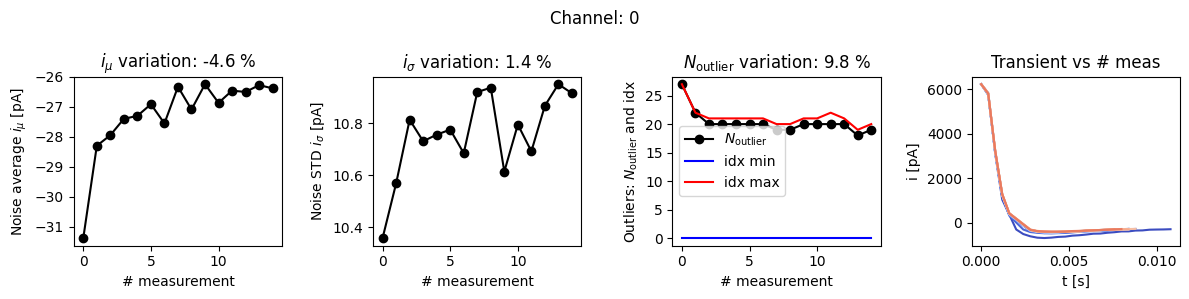

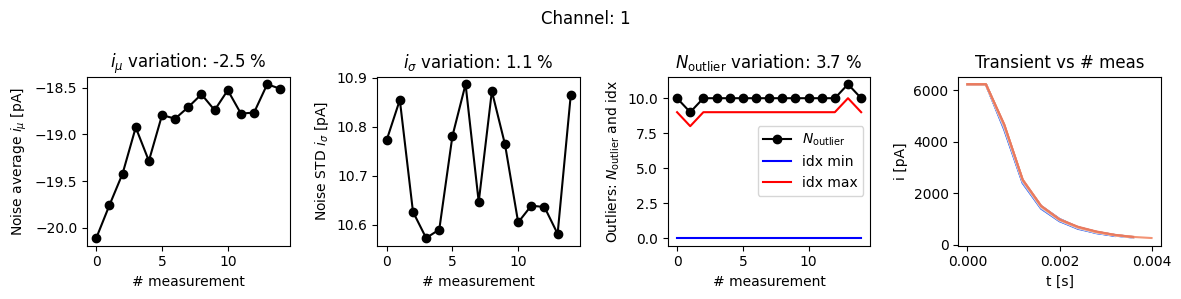

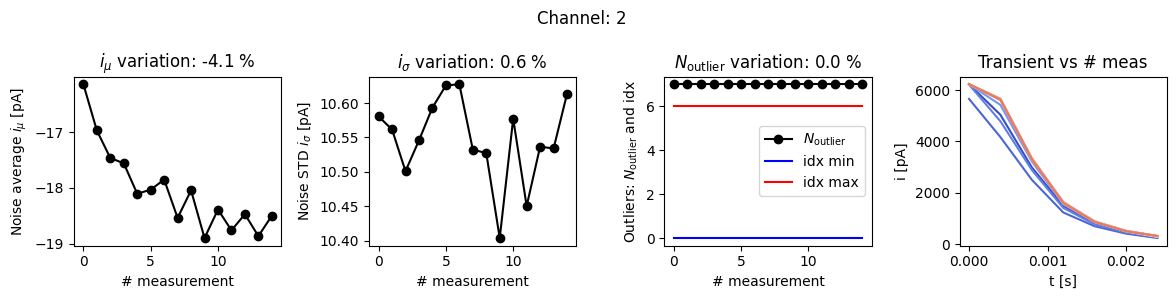

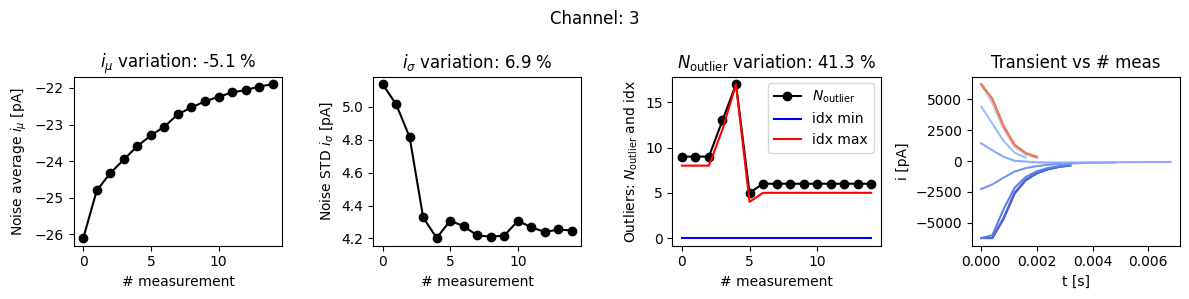

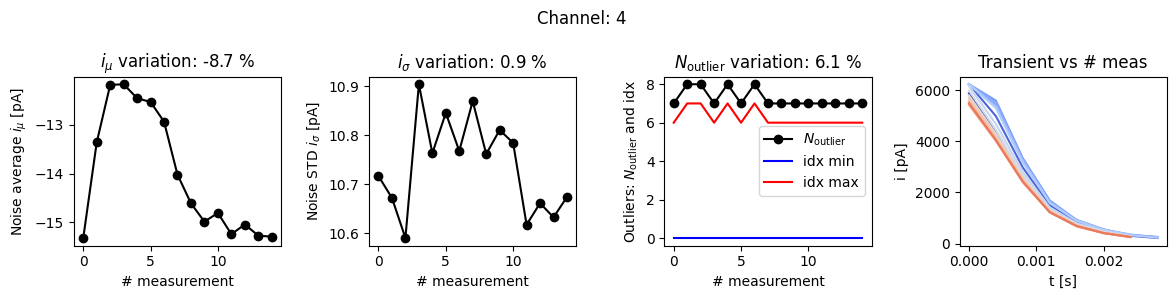

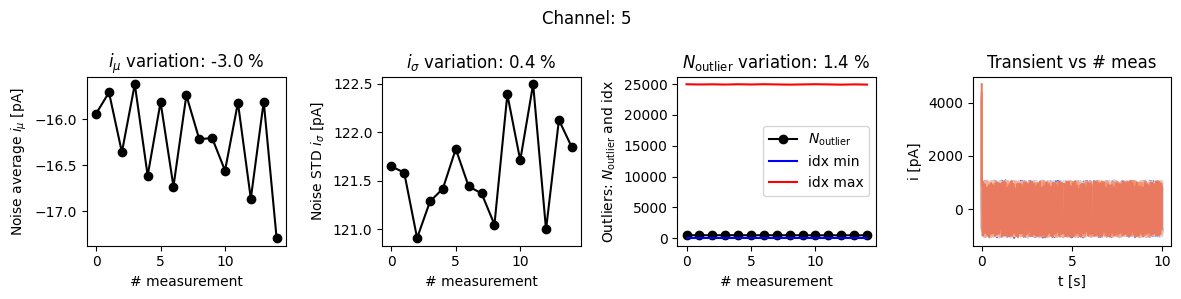

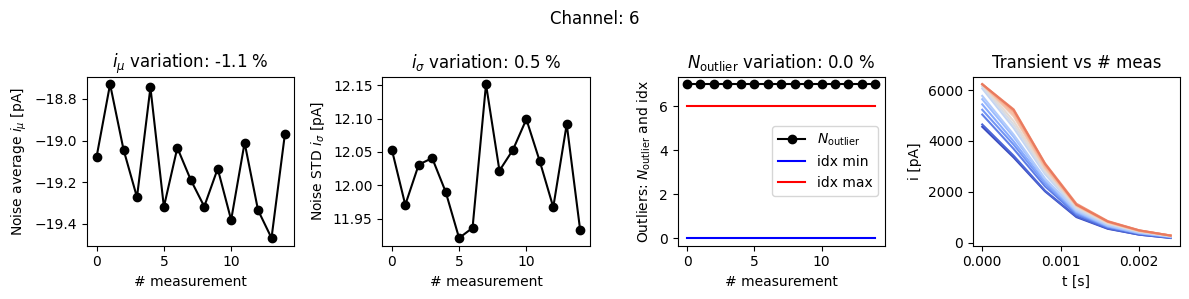

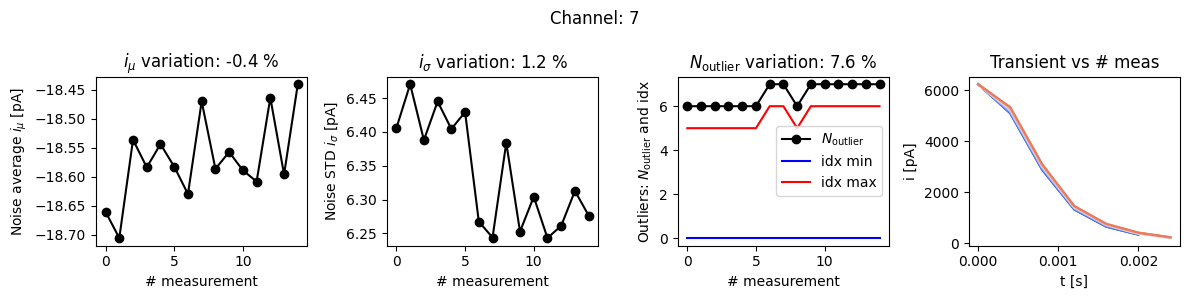

In [5]:
filename_pic = 'fig_noise_data'

path_output = 'task_1_noise_analysis_output_v2/'

for idx_channel in range(8):

    # idx_channel = 0
    N_meas = 15 # 15
    N_cols = 4

    outlier_n_std = 4

    if not os.path.exists(path_output):
        print(f'Output folder {path_output} not found. Creating a new one.')
        os.makedirs(path_output)

    i_good_mus = np.zeros(N_meas, dtype=np.float64)
    i_good_sigmas = np.zeros(N_meas, dtype=np.float64)
    i_N_bad = np.zeros(N_meas, dtype=np.int32)
    idx_bad_min = np.zeros(N_meas, dtype=np.int32)
    idx_bad_max = np.zeros(N_meas, dtype=np.int32)

    i_idx_bads = []

    # Load all data for selected channel
    for idx_meas in range(N_meas):
        t, i = get_data(idx_meas, idx_channel)
        sp, idx_good, idx_bad = get_i_stat(i, outlier_n_std=outlier_n_std)
        i_good_mus[idx_meas] = sp['i_good_mu']
        i_good_sigmas[idx_meas] = sp['i_good_sigma']
        i_N_bad[idx_meas] = sp['N_bad']
        idx_bad_min[idx_meas] = np.min(idx_bad)
        idx_bad_max[idx_meas] = np.max(idx_bad)
        i_idx_bads.append(idx_bad)

        if idx_meas == 0: # initialize i_chs
            i_chs = np.zeros(shape=(N_meas, len(t)), dtype=np.float64)

        i_chs[idx_meas, :] = i[:]

    i_chs_mu = np.mean(i_chs, axis=0)
    i_chs_sigma = np.std(i_chs, axis=0)



    # Repeatability
    fig, ax = plt.subplots(ncols=4, figsize=(12, 3))

    cmap1 = plt.cm.coolwarm
    gcol1 = cmap1(np.arange(0, 255, 256//(N_meas+2)))

    bax = ax[0]
    bax.plot(i_good_mus, color='k', marker='o')
    bax.set_xlabel('# measurement')
    bax.set_ylabel('Noise average $i_\mu$ [pA]')
    bax.set_title(f'$i_\mu$ variation: {100*np.std(i_good_mus)/np.mean(i_good_mus):.1f} %')

    bax = ax[1]
    bax.plot(i_good_sigmas, color='k', marker='o')
    bax.set_xlabel('# measurement')
    bax.set_ylabel('Noise STD $i_\sigma$ [pA]')
    bax.set_title(f'$i_\sigma$ variation: {100*np.std(i_good_sigmas)/np.mean(i_good_sigmas):.1f} %')

    bax = ax[2]
    bax.plot(i_N_bad, color='k', marker='o', label='$N_\mathrm{outlier}$')
    bax.plot(idx_bad_min, color='b', label='idx min')
    bax.plot(idx_bad_max, color='r', label='idx max')
    bax.set_xlabel('# measurement')
    bax.set_ylabel('Outliers: $N_\mathrm{outlier}$ and idx')
    bax.set_title('$N_\mathrm{outlier}$'+f' variation: {100*np.std(i_N_bad)/np.mean(i_N_bad):.1f} %')
    bax.legend()

    bax = ax[3]
    for idx_meas in range(N_meas):
        idx_bad = i_idx_bads[idx_meas]
        bax.plot(t[idx_bad], i_chs[idx_meas, :][idx_bad], color=gcol1[idx_meas], label=str(idx_meas))

    bax.set_xlabel('t [s]')
    bax.set_ylabel('i [pA]')
    bax.set_title('Transient vs # meas')

    fig.suptitle(f'Channel: {idx_channel}')

    plt.tight_layout()
    plt.savefig(f'{path_output}{filename_pic}_ch{idx_channel}_N_meas{N_meas:02}_rep.png', dpi=300)



## Task 3: Identify, quantify and visualize any corrupted channels


The most obvious case is channel 5. Unlike other channels, it does not have a transient region followed by a flat noisy steady state. It has, instead, several frequency components (seen in the FFT spectra) onto which the noise is superimposed. Considering that this is not the expected response to applying a constant potential, we can state with high confidence that channel 5 is corrupt.

The channel 3 is very suspicious because, although the statistical parameters of its noise seem alright, its transient is very inconsistent, with its response even changing polarity. Assuming this not to be due to an improper testing set up (such as not setting an important control parameter), this kind of response volatility is most likely an indication of an corrupt channel.

Channels 2, 4 and 6 seem to be good in terms of noise statistics and transient, but they feature a clear drift of the transient response over repeated measurements. This is seen from the fact that the blue->white->red ordering of the colormap used in drawing the lines is preserved (especially for channel 6), meaning that spread of the transient curves is not random but the there is a gradual, systematic drift. Assuming this is not due to improper testing (such as insufficient time for sensor reseting), this is an issue that needs to be addressed by considering the underlying sensor/channel physics and specifications.

Channels 0, 1 and 7 show a very regular behavior and high consistency over repeated measurements and, consequently, we can state with high confidence that these channels operate an expected.

In summary:

Channel 0: Good

Channel 1: Good

Channel 2: Unclear/Suspicious drift

Channel 3: Bad/Inconsistent response

Channel 4: Unclear/Suspicious drift

Channel 5: Bad/Spurious frequency components

Channel 6: Unclear/Suspicious drift

Channel 7: Good